In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from deep_translator import GoogleTranslator
import pickle
import os
import re
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from nltk.tokenize import sent_tokenize

In [16]:
print("Code started")

# Load the dataset
data = pd.read_csv('news_articles.csv')

# Combine preprocessed title and text columns
data['combined_clean_text'] = data['title_without_stopwords'] + " " + data['text_without_stopwords']

# Label encoding for target variable (Real/Fake)
label_encoder = LabelEncoder()
data['label'] = data['label'].map({'Fake': 0, 'Real': 1})

def clean_text(text):
    """Ensure input is a string and handle NaN values."""
    if not isinstance(text, str):
        return ""
    # Convert to lowercase and remove punctuation
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text


translator = GoogleTranslator(source='en', target='fr')

def back_translate(text, src='en', dest='fr', max_length=500):
    """Performs back translation with truncation."""
    text = clean_text(text)  # Ensure the input is a string
    if not text:  # If text is empty or None, return it as is
        return text
    # Truncate text to avoid issues with excessively long inputs
    if len(text) > max_length:
        text = text[:max_length]
    try:
        # Translate to target language
        translated = GoogleTranslator(source=src, target=dest).translate(text)
        # Translate back to original language
        return GoogleTranslator(source=dest, target=src).translate(translated)
    except Exception as e:
        print(f"Error in back translation: {e}")
    # If translation fails, return the original text
    return text


def split_long_text(row, max_length=500):
    """Split long text into multiple rows if it exceeds max_length, preferably at sentence boundaries."""
    text = clean_text(row['combined_clean_text'])  # Ensure the input is a string
    if len(text) <= max_length:
        return [row]
    else:
        sentences = sent_tokenize(text)
        split_rows, current_text = [], ""
        for sentence in sentences:
            if len(current_text) + len(sentence) <= max_length:
                current_text += " " + sentence
            else:
                new_row = row.copy()
                new_row['combined_clean_text'] = current_text.strip()
                split_rows.append(new_row)
                current_text = sentence
        # Append any remaining text
        if current_text:
            new_row = row.copy()
            new_row['combined_clean_text'] = current_text.strip()
            split_rows.append(new_row)
        return split_rows

# Apply preprocessing and back translation to the dataset
try:
    # Split long text rows into multiple rows
    split_data = []
    for _, row in data.iterrows():
        split_data.extend(split_long_text(row))
    data = pd.DataFrame(split_data)

    data['augmented_text'] = data['combined_clean_text'].apply(
        lambda x: back_translate(x) if np.random.rand() < 0.3 else x  # Translate 30% of the samples
    )
    data['augmented_text'] = data['augmented_text'].fillna('')  # Handle missing text
except Exception as e:
    print(f"Error during preprocessing: {e}")

Code started


In [18]:
# Encode metadata features
data['author_encoded'] = LabelEncoder().fit_transform(data['author'])
data['type_encoded'] = LabelEncoder().fit_transform(data['type'])
data['site_url_encoded'] = LabelEncoder().fit_transform(data['site_url'])
data['days_since_published'] = pd.to_datetime(data['published'], errors='coerce', utc=True)
data['days_since_published'] = data['days_since_published'].dt.tz_convert(None)  # Remove timezone info if not needed
# Compute the difference in days and normalize
data['days_since_published'] = (pd.Timestamp.now() - data['days_since_published']).dt.days.fillna(0).astype(int)

# Normalize days_since_published to bring values into a consistent range
data['days_since_published'] = (data['days_since_published'] - data['days_since_published'].min()) / (data['days_since_published'].max() - data['days_since_published'].min())

# Remove rows with NaN labels
data = data.dropna(subset=['label'])

# Extract metadata features
metadata_features = data[['author_encoded', 'type_encoded', 'hasImage', 'days_since_published', 'site_url_encoded']].values

# Scaling metadata features
scaler = StandardScaler()
scaled_metadata_features = scaler.fit_transform(metadata_features)


In [20]:
# Create TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_features = vectorizer.fit_transform(data['augmented_text']).toarray()

In [22]:
# Concatenate metadata features with TF-IDF features
X_combined = np.hstack([scaled_metadata_features, tfidf_features])
labels = data['label'].values

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_combined, labels = smote.fit_resample(X_combined, labels)

# Apply PCA to reduce dimensionality, keeping 95% of the variance
pca = PCA(n_components=0.95)
X_combined = pca.fit_transform(X_combined)

# Train-test split for combined model
X_train, X_test, y_train, y_test = train_test_split(X_combined, labels, test_size=0.2, random_state=42)


In [23]:
# Define the models to use
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
}

In [24]:

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print("Best parameters for Random Forest:", grid_search_rf.best_params_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
226 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\aksha\anaconda3\Lib\site-packa

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}


In [25]:
# Hyperparameter tuning for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

lr = LogisticRegression(max_iter=1000, random_state=42)
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}


C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [26]:
# Hyperparameter tuning for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb = GradientBoostingClassifier(random_state=42)
random_search_gb = RandomizedSearchCV(estimator=gb, param_distributions=param_grid_gb, n_iter=50, cv=5, n_jobs=-1, random_state=42, verbose=2)
random_search_gb.fit(X_train, y_train)
best_gb = random_search_gb.best_estimator_
print("Best parameters for Gradient Boosting:", random_search_gb.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Gradient Boosting: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 7, 'learning_rate': 0.2}


In [27]:
# Train and evaluate each tuned model
models = {
    "Random Forest": best_rf,
    "Logistic Regression": best_lr,
    "Gradient Boosting": best_gb
}

Random Forest Cross-Validation Accuracy: 0.9426 (+/- 0.0117)
Random Forest Test Accuracy: 0.9478
Random Forest ROC AUC Score: 0.9479
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       469
         1.0       0.94      0.95      0.95       451

    accuracy                           0.95       920
   macro avg       0.95      0.95      0.95       920
weighted avg       0.95      0.95      0.95       920



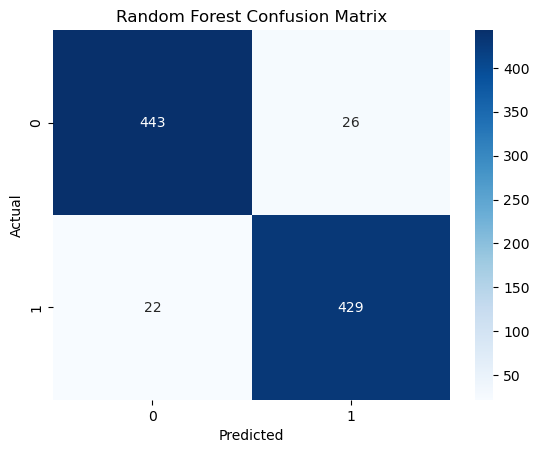

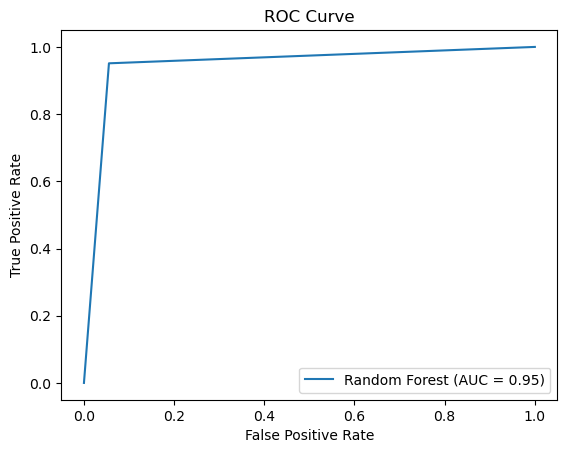

C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Cross-Validation Accuracy: 0.8020 (+/- 0.0153)
Logistic Regression Test Accuracy: 0.8022
Logistic Regression ROC AUC Score: 0.8021
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81       469
         1.0       0.80      0.80      0.80       451

    accuracy                           0.80       920
   macro avg       0.80      0.80      0.80       920
weighted avg       0.80      0.80      0.80       920



C:\Users\aksha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


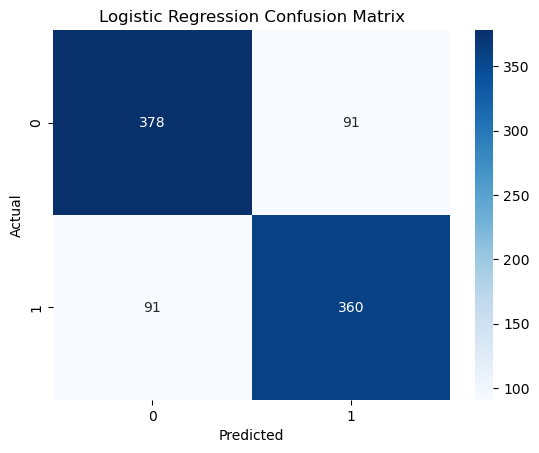

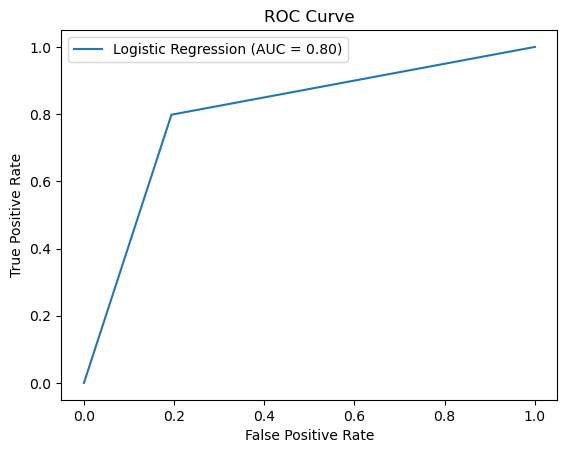

Gradient Boosting Cross-Validation Accuracy: 0.9954 (+/- 0.0039)
Gradient Boosting Test Accuracy: 0.9957
Gradient Boosting ROC AUC Score: 0.9956
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       469
         1.0       1.00      0.99      1.00       451

    accuracy                           1.00       920
   macro avg       1.00      1.00      1.00       920
weighted avg       1.00      1.00      1.00       920



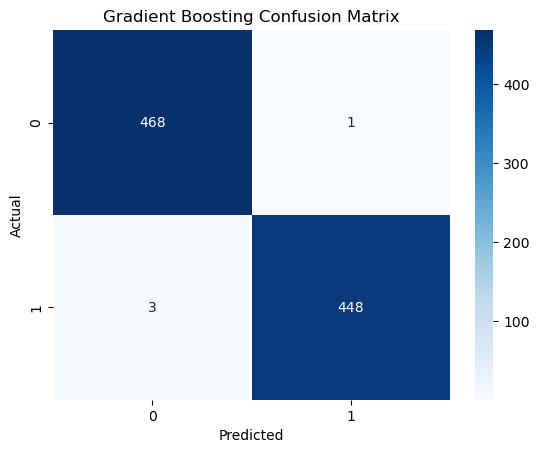

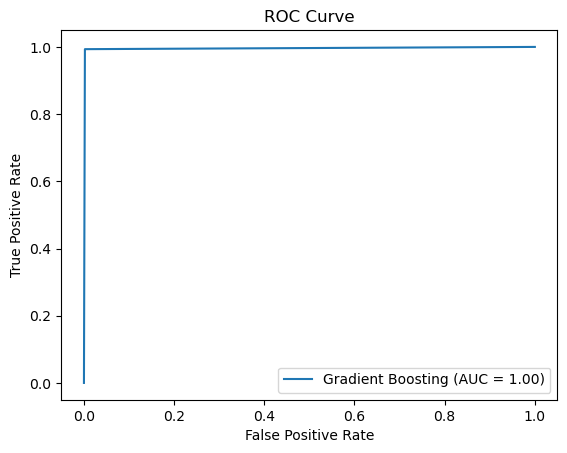

In [28]:
best_model = None
best_accuracy = 0

for model_name, model in models.items():
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"{model_name} Test Accuracy: {accuracy:.4f}")
    print(f"{model_name} ROC AUC Score: {roc_auc:.4f}")
    print(f"{model_name} Classification Report:\n{classification_report(y_test, y_pred)}")
    
    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    # Keep track of the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

In [42]:
# Save the best Random Forest model
import pickle
import os

# Save the Random Forest model
output_model_dir = './saved_best_model'
os.makedirs(output_model_dir, exist_ok=True)
model_save_path = os.path.join(output_model_dir, 'random_forest_model.pkl')
with open(model_save_path, 'wb') as f:
    pickle.dump(best_rf, f)

print(f'Random Forest model saved to {output_model_dir}')

# Save metadata such as label encoder and scaler
metadata = {
    'label_encoder': label_encoder,
    'scaler': scaler,
    'vectorizer': vectorizer
}
metadata_save_path = os.path.join(output_model_dir, 'metadata.pkl')
with open(metadata_save_path, 'wb') as f:
    pickle.dump(metadata, f)

print(f'Metadata saved to {output_model_dir}')


Random Forest model saved to ./saved_best_model
Metadata saved to ./saved_best_model
